# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import os

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
objCase = 7

def energyStr (paramsE) :
    Efloat = float(paramsE)
    Eint = int(np.floor(Efloat))

    if Efloat - Eint == 0 :
        return "E" + str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return "E" + str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    # First term is the MSE, second term is used to constrain the probability to 1.
    if objCase == 1 :
        return np.mean(diffeq**2) + (1 - prob)**2 + 4/prob + (prob**4)
    elif objCase == 2 :
        return np.mean(diffeq**2) + (1 - prob)**2 + 10/prob + (10/4)*(prob**4)
    elif objCase == 3 :
        return np.mean(diffeq**2) + 100*(1 - prob)**2 + 1000/prob + (1000/4)*(prob**4)
    elif objCase == 4 :
        return np.mean(diffeq**2) + (1-prob)**2 + (10/prob + 10*prob) + ((1/4)/prob**2 + (1/4)*prob**2)
    elif objCase == 5 :
        return np.mean(diffeq**2) + (1-prob)**2 + (20/prob + 2*prob) + (1/prob**2 + 10*prob**2)
    elif objCase == 6 :
        return np.mean(diffeq**2) + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3)
    elif objCase == 7 :
        return np.mean(diffeq**2) + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3) + (5/(8*prob**4) + (5/8)*prob**4)

iterList = []
diffeqList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    if objCase == 1 :
        loss = mean + (1-prob)**2 + 4/prob + (prob**4)
    elif objCase == 2 :
        loss = mean + (1 - prob)**2 + 10/prob + (10/4)*(prob**4)
    elif objCase == 3 :
        loss = mean + 100*(1-prob)**2 + 1000/prob + (1000/4)*(prob**4)
    elif objCase == 4 :
        loss = mean + (1-prob)**2 + (10/prob + 10*prob) + ((1/4)/prob**2 + (1/4)*prob**2)
    elif objCase == 5 :
        loss = mean + (1-prob)**2 + (20/prob + 2*prob) + (1/prob**2 + 10*prob**2)
    elif objCase == 6 :
        loss = mean + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3)
    elif objCase == 7 :
        loss = mean + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3) + (5/(8*prob**4) + (5/8)*prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))
    
    print ("Iteration " + str(step) + " diffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("---------------------------------")
    

# Callback function.
def callback(params, step, g):
    if step % 100 == 0:
        objectiveDebug (params, step)

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 1 # Length of the well
n = 3 # Energy level to be found
scale = 2 # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# The ground state energy of the particle in a box is (pi^2)/2 = 4.9348. I've initialised E to 4.0
# so that it converges to the eigenenergy quickly.
initE = 75.0
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + str(L) + energyStr(params['E'])

# Optimization

In [6]:
params = adam(grad(objective), params,
              step_size=0.001, num_iters=10001, callback=callback) 

Iteration 0 diffeq = 16820.673147997113 prob = 3.5325060280642115
loss = 17979.56297059332 E = 75.0
---------------------------------
Iteration 100 diffeq = 332.7107682073841 prob = 0.6051192191910584
loss = 725.1221282426928 E = 74.97215983409684
---------------------------------
Iteration 200 diffeq = 131.25545960483683 prob = 0.6196820452203899
loss = 515.5858242494372 E = 74.96603816537883
---------------------------------
Iteration 300 diffeq = 107.2339812947966 prob = 0.6637053611454286
loss = 471.01956904119845 E = 74.96863860056894
---------------------------------
Iteration 400 diffeq = 88.67289129800665 prob = 0.6951980748752289
loss = 440.7575552172416 E = 74.97494140862315
---------------------------------
Iteration 500 diffeq = 75.00287073565325 prob = 0.7036294598735187
loss = 424.31553099216666 E = 74.98382885107188
---------------------------------
Iteration 600 diffeq = 66.98435165080515 prob = 0.7126476632693121
loss = 413.4862502821285 E = 74.99483326648884
---------

Iteration 5500 diffeq = 2.2959715303130417 prob = 0.9951514779850372
loss = 313.55296377570613 E = 77.45510355290244
---------------------------------
Iteration 5600 diffeq = 2.112418735846091 prob = 0.9955548676408419
loss = 313.3682935143145 E = 77.51714254515795
---------------------------------
Iteration 5700 diffeq = 1.9386850771684316 prob = 0.9959490097729473
loss = 313.19356230234376 E = 77.57850069208337
---------------------------------
Iteration 5800 diffeq = 1.7745055092425168 prob = 0.9963012114215468
loss = 313.028570093233 E = 77.63912213869794
---------------------------------
Iteration 5900 diffeq = 1.619995659633118 prob = 0.9965795118021713
loss = 312.8734706385924 E = 77.69894928101259
---------------------------------
Iteration 6000 diffeq = 1.4741246676700144 prob = 0.9969189266152405
loss = 312.72694326117636 E = 77.75793927126047
---------------------------------
Iteration 6100 diffeq = 1.3374641823826898 prob = 0.9971948028524344
loss = 312.5897999799699 E = 77

# Plots

In [7]:
replot = 1
if replot == 1 :
    params['E'] = initE
    n = 4
    L = 1
    name = "n" + str(n)+ "L" + str(L) + energyStr(params['E'])

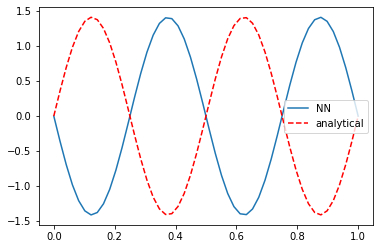

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

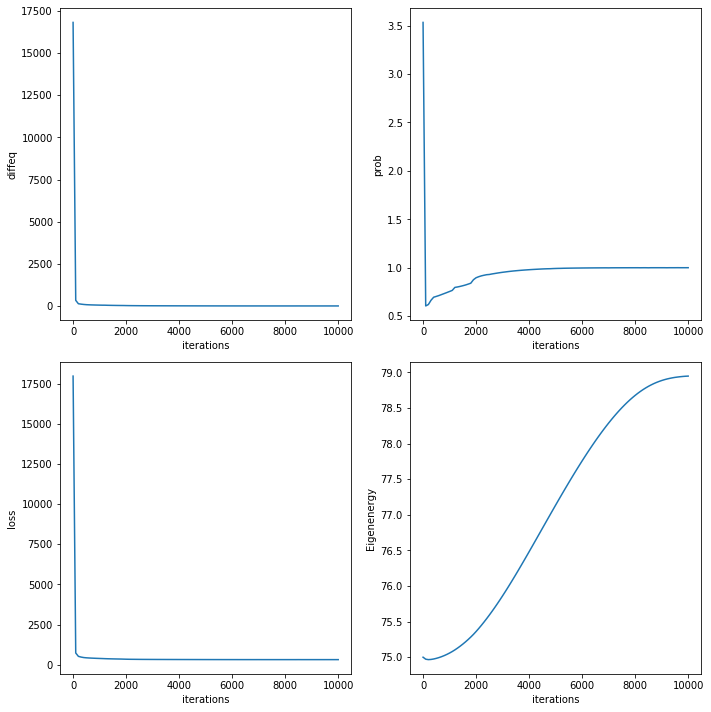

In [9]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

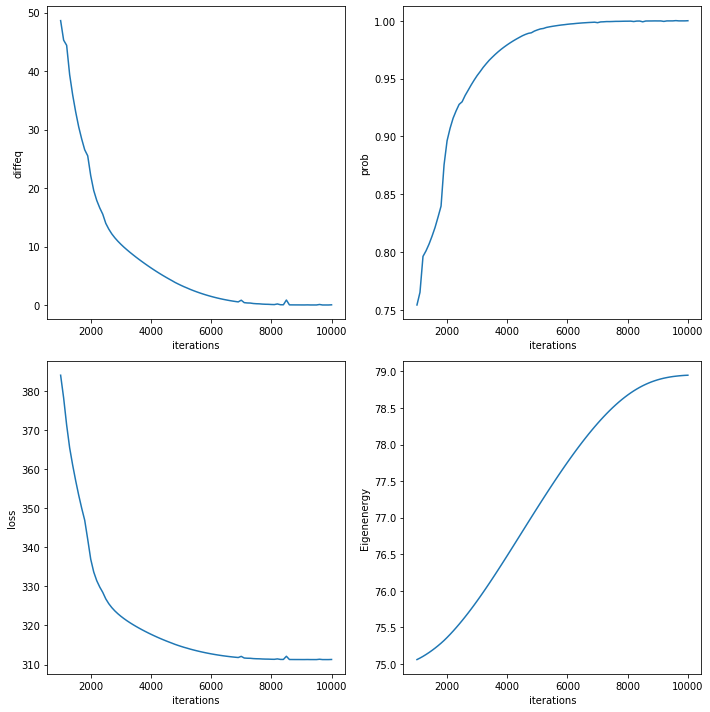

In [10]:
fig = plt.figure (figsize=(10,10))
trunc = 10

plt.subplot (2 , 2 , 1)
plt.plot (iterList[trunc:], diffeqList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList[trunc:], probList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList[trunc:], lossList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList[trunc:], EList[trunc:])
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

# Write to file

In [11]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + "\nprob = " + str(round(probList[-1],8)) + "\nloss = " + str(round(lossList[-1],8)) + "\neigE = " + str(round(EList[-1],8))
    
outfile.write (fstr)
outfile.close ()

In [12]:
print ("\diffeq = " + str(round(diffeqList[-1],8)) + ", \prob = " + str(round(probList[-1],8)) + 
       ", \loss = " + str(round(lossList[-1],8)) + ", \eigE = " + str(round(EList[-1],8)))

\diffeq = 0.03836215, \prob = 0.99997513, \loss = 311.28836233, \eigE = 78.94901754
